In [3]:
import pandas as pd, sys
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime, calendar, time
import matplotlib.dates as mdates
import matplotlib.colors as colors
import matplotlib.ticker
%matplotlib inline

In [48]:
PLACE = "new-york_new-york"

Read in the versions file

In [49]:
header = ['id',        
          'type',
          'amenity',
          'highway',
          'building',
          'name',
          'length',
          'area',
          'aA',
          'aD',
          'aM',
          'user',
          'version',
          'minorVersion',
          'validSince',
          'validUntil',
          'geometry']

In [50]:
df = pd.read_csv('../data/'+PLACE+'-all-stats.data',names=header, sep='\t',index_col=None)
df.head(2)

,id,type,amenity,highway,building,name,length,area,aA,aD,aM,user,version,minorVersion,validSince,validUntil,geometry
0,525459854,node,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mario824,1,NaN,1255002073,1343072729,"-76.1380683,41.0643062"
1,525459854,node,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mario824,2,NaN,1343072729,1349025794,"-76.1380164,41.0644374"


In [51]:
df.sort_values(by='validSince',inplace=True)
df = df.reset_index(drop=True)
df.head(2)

,id,type,amenity,highway,building,name,length,area,aA,aD,aM,user,version,minorVersion,validSince,validUntil,geometry
0,28438458,node,NaN,motorway_junction,NaN,NaN,NaN,NaN,created_by-->JOSM,NaN,NaN,Adam Killian,1,NaN,1178080967,1254114294,"-74.1038801,40.6910599"
1,30366390,node,NaN,motorway_junction,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bridger,1,NaN,1181857799,1238628172,"-74.6594093,40.6434825"


Calculate new columns and convert to Python objects

In [52]:
df['date'] = df.validSince.apply(lambda x: pd.Timestamp(x*1000000000).date())
df.replace("false", np.NaN, inplace=True)
df.validUntil = df['validUntil'].astype(float)

In [53]:
df.id.count(), df.id.nunique(), df.user.nunique(), df.query('version==1').id.count()

(3494162, 2233930, 7857, 2316783)

In [54]:
#Cast length and area to floats
df.length = pd.to_numeric(df.length, downcast='float')
df.area = pd.to_numeric(df.length, downcast='float')
df.version = pd.to_numeric(df.version, downcast='integer')

In [55]:
df.dtypes

id                int64
type             object
amenity          object
highway          object
building         object
name             object
length          float32
area            float32
aA               object
aD               object
aM               object
user             object
version            int8
minorVersion    float64
validSince        int64
validUntil      float64
geometry         object
date             object
dtype: object

# 1. Kilometers of roads overtime

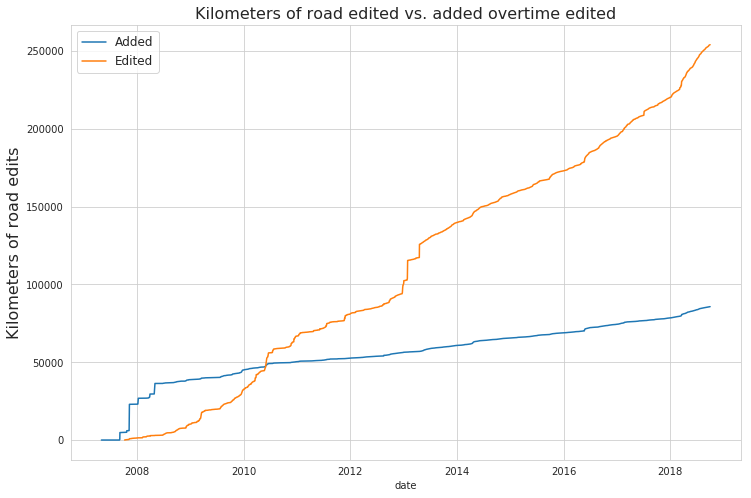

In [56]:
sns.set_style('whitegrid')
hw = df[~pd.isnull(df.highway)]
ax = hw[hw.version==1].groupby('date').aggregate({'length':sum}).cumsum().plot(figsize=(12,8),legend=None)
hw[hw.version>1].groupby('date').aggregate({'length':sum}).cumsum().plot(ax=ax,legend=None)
ax.set_ylabel("Kilometers of road edits",fontsize=16)
ax.set_title("Kilometers of road edited vs. added overtime edited",fontsize=16);
ax.legend(['Added','Edited'], loc=0, fontsize=12);

# 2 Buildings Overtime

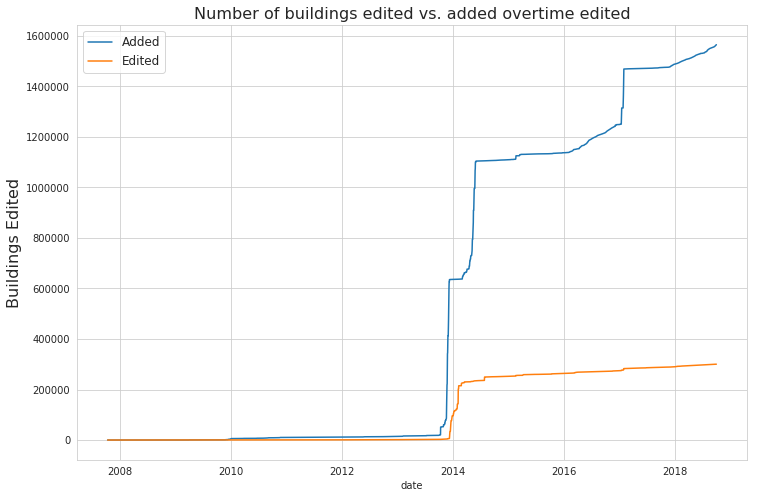

In [57]:
sns.set_style('whitegrid')
buildings = df[~pd.isnull(df.building)]
ax = buildings[buildings.version==1].groupby('date').aggregate({'id':'nunique'}).cumsum().plot(figsize=(12,8),legend=None)
buildings[buildings.version>1].groupby('date').aggregate({'id':'nunique'}).cumsum().plot(ax=ax,legend=None)
ax.set_ylabel("Buildings Edited",fontsize=16)
ax.set_title("Number of buildings edited vs. added overtime edited",fontsize=16);
ax.legend(['Added','Edited'], loc=0, fontsize=12);

# 3 What about Amenities?

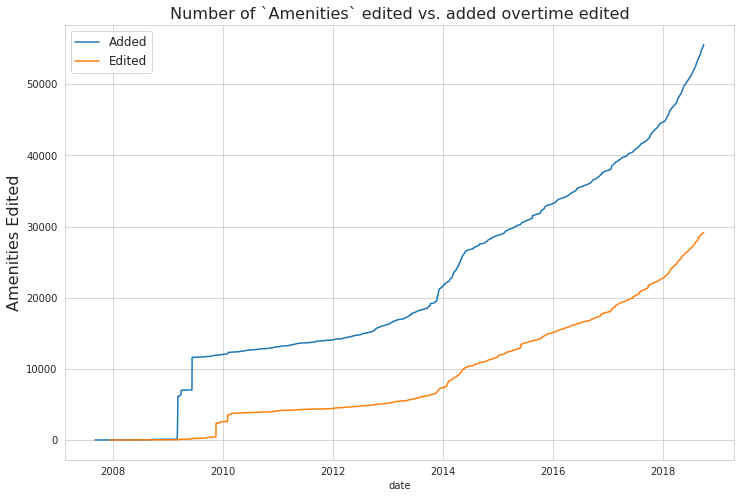

In [58]:
sns.set_style('whitegrid')
amenities = df[~pd.isnull(df.amenity)]
ax = amenities[amenities.version==1].groupby('date').aggregate({'id':'nunique'}).cumsum().plot(figsize=(12,8),legend=None)
amenities[amenities.version>1].groupby('date').aggregate({'id':'nunique'}).cumsum().plot(ax=ax,legend=None)
ax.set_ylabel("Amenities Edited",fontsize=16)
ax.set_title("Number of `Amenities` edited vs. added overtime edited",fontsize=16);
ax.legend(['Added','Edited'], loc=0, fontsize=12);

# 4 Contributors per week ... an editing pulse?

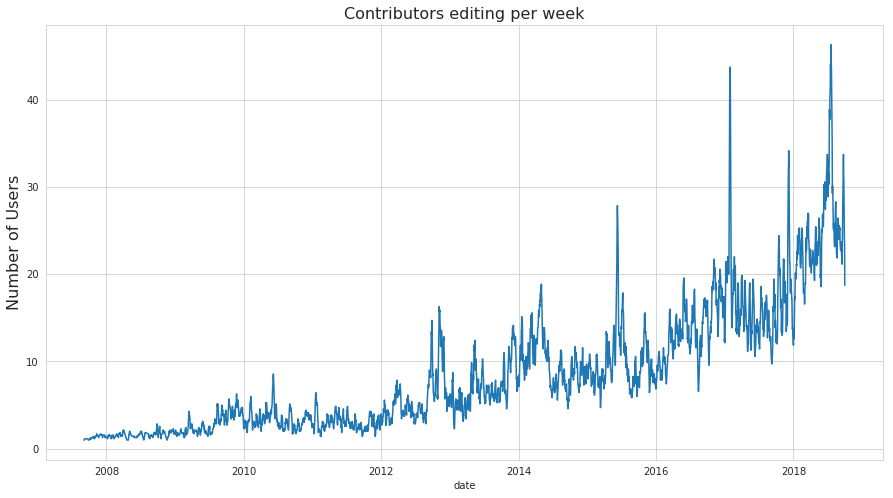

In [59]:
ax = df.groupby('date').aggregate({'user':'nunique'}).rolling(7).mean().plot(figsize=(15,8),legend=None)
ax.set_ylabel("Number of Users",fontsize=16)
ax.set_title("Contributors editing per week",fontsize=16);

# 5 Edits per week?

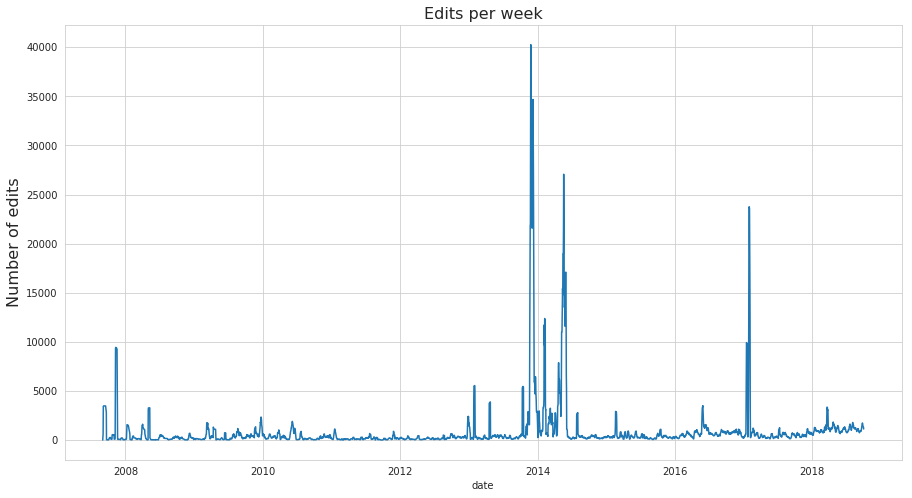

In [60]:
ax = df.groupby('date').aggregate({'id':'count'}).rolling(7).mean().plot(figsize=(15,8),legend=None)
ax.set_ylabel("Number of edits",fontsize=16)
ax.set_title("Edits per week",fontsize=16);

# 6 Users overtime

In [61]:
def get_unique_users_overtime(df):
    """ Function to count unique users overtime in a dataframe
        Input: Dataframe
        Returns: Dataframe
    """
    allUsers = []
    dates = {}
    size=len(df)
    for idx, row in df.sort_values(by='validSince').iterrows():
        if row.user not in allUsers:
            if row.date in dates:
                dates[row.date]+=1
            else:
                dates[row.date]=1
            allUsers.append(row.user)
        if (idx%10000==0):
            sys.stderr.write('\rProcessed '+str(idx)+" rows of "+str(size))
    dates2 = []
    for date, value in dates.items():
        dates2.append({'date':date, 'count':value})
    return pd.DataFrame(sorted(dates2,key=lambda d: d['date']))

In [ ]:
unique_users_over_time = get_unique_users_overtime(df)
unique_users_over_time['cumulative'] = unique_users_over_time['count'].cumsum()
unique_users_over_time.head(2)

Processed 10000 rows of 3494162

In [ ]:
sns.set_style('whitegrid')
ax = unique_users_over_time.plot(x='date',y='cumulative',figsize=(15,8),legend=None)
ax.set_ylabel('Number of Unique Contributors', fontsize=15);
ax.set_xlabel('Year', fontsize=15);

# 7 Contributor Co-Editing Network

In [ ]:
import networkx as nx

In [ ]:
G = nx.DiGraph()
for line in open('../data/'+PLACE+'-users.edgelist','r'):
    sourceLabel, targetLabel, weight = line.split(",")
    weight = int(weight)
    if weight > 100:
        G.add_edge(sourceLabel, targetLabel, weight=weight)

In [ ]:
len(G.nodes())

In [ ]:
nx.draw_spring(G, figsize=(15,8), with_labels=True)

# Where was editing done in detroit?

In [128]:
import shapely, json
from shapely import geometry
df.date.min() - datetime.date(2005,1,1)

datetime.timedelta(572)

In [134]:
for TYPE in ['building', 'highway','amenity','newName']:
    point_collection = {'type':'FeatureCollection','features':[]}
    for date, edits in df[df[TYPE].notnull()].groupby('date'):
        points = geometry.MultiPoint( edits.center.apply(lambda x: geometry.Point([float(y) for y in x.split(",")])).values )
        #print(json.dumps(geometry.mapping(points)))
        geojson = {
            'geometry':geometry.mapping(points),
            'type':"Feature",
            'properties': {'days_since_2005': (date - datetime.date(2005,1,1) ).days, 'edits':len(edits)}
        }
        point_collection['features'].append(geojson)

    json.dump(point_collection, open("../docs/data/"+PLACE+"-"+TYPE+"-points.geojson",'w'))

In [12]:
latest_versions = df.query("validUntil=={0}".format(TIME_NOW))

When were objects created in Detroit?

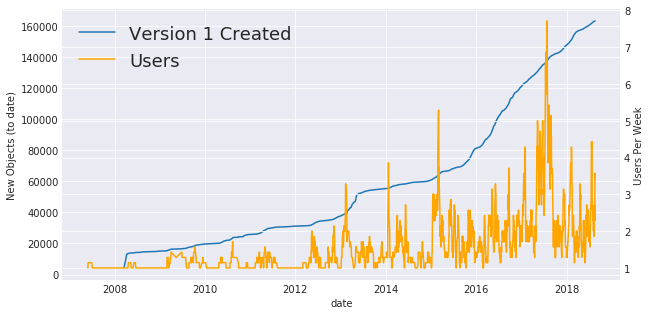

In [16]:
gb_dates = df.query('version==1').groupby('date').aggregate({'id':pd.Series.count, 'user': pd.Series.nunique})
sns.set_style("darkgrid"); axes = []
axes.append( gb_dates.id.cumsum().rolling(window=30).mean().plot(figsize=(10,5)) )
axes.append( gb_dates.user.rolling(window=7).mean().plot(figsize=(10,5), color='orange', ax=axes[0].twinx()) )
lines, labels = axes[0].get_legend_handles_labels()
for ax in axes[1:]:
    line, label = ax.get_legend_handles_labels()
    lines += line
axes[-1].legend(lines, ['Version 1 Created','Users'], loc=0, fontsize=18);
axes[0].set_ylabel('New Objects (to date)');
axes[1].set_ylabel('Users Per Week');

What about the latest edits to buildings?

In [322]:
gb_dates = latest_versions.groupby('date').aggregate({'id':pd.Series.count, 'user': pd.Series.nunique})

In [323]:
sns.set_style("darkgrid"); axes = []
axes.append( gb_dates.id.cumsum().rolling(window=30).mean().plot(figsize=(10,5)) )
axes.append( gb_dates.user.cumsum().rolling(window=30).mean().plot(figsize=(10,5), color='orange', ax=axes[0].twinx()) )
lines, labels = axes[0].get_legend_handles_labels()
for ax in axes[1:]:
    line, label = ax.get_legend_handles_labels()
    lines += line
axes[-1].legend(lines, ['Building Edits','Users'], loc=0, fontsize=18);
axes[0].set_ylabel('Building Count (to date)');
axes[1].set_ylabel('User Count (to date)');

TypeError: Empty 'DataFrame': no numeric data to plot

How long between building edits?

In [324]:
buildings.lifespan.hist()

AttributeError: 'DataFrame' object has no attribute 'lifespan'

# Versions

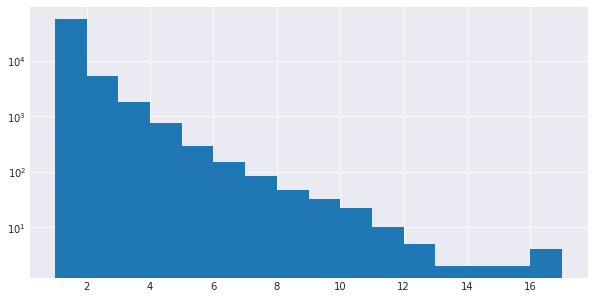

In [325]:
ax = buildings.version.hist(figsize=(10,5),bins=np.arange(1,buildings.version.max(),1))
ax.set_yscale('log')

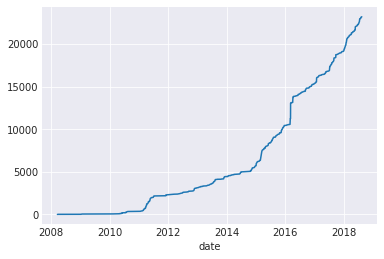

In [332]:
buildings.query('version>1').groupby('date').aggregate({'user':pd.Series.nunique, 'version':sum}).version.cumsum().plot()

In [244]:
buildings.sort_values(by='version', ascending=False)

,id,user,version,minVersion,validSince,validUntil,name,date,lifespan
2189376,190954764,amritkarma,315,0.0,1386477495,1535673544,NaN,2013-12-08,149196049
2189375,190954764,Manoj Thapa,314,0.0,1378293746,1386477495,NaN,2013-09-04,8183749
2189374,190954764,amritkarma,313,0.0,1373605537,1378293746,NaN,2013-07-12,4688209
2189373,190954764,Nepal-Mapper,312,0.0,1367394313,1373605537,NaN,2013-05-01,6211224
2189372,190954764,KTM-Mappers,311,0.0,1366648507,1367394313,NaN,2013-04-22,745806
2189371,190954764,KTM-Mappers,310,0.0,1366276801,1366648507,NaN,2013-04-18,371706
2189370,190954764,KTM-Mappers,309,0.0,1366276780,1366276801,NaN,2013-04-18,21
2189369,190954764,KTM-Mappers,308,0.0,1366276738,1366276780,NaN,2013-04-18,42
2189368,190954764,KTM-Mappers,307,0.0,1366276667,1366276738,NaN,2013-04-18,71
2189367,190954764,KTM-Mappers,306,0.0,1366276304,1366276667,NaN,2013-04-18,363


# Learning about Names

In [245]:
buildings_gb_date = buildings[buildings.name.notnull()].groupby('date')

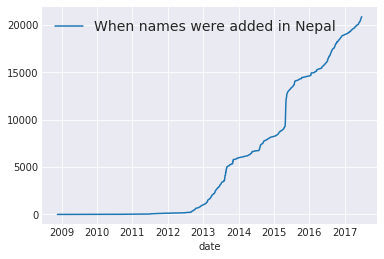

In [284]:
sns.set_style('darkgrid')
ax = buildings_gb_date.aggregate({'id':'nunique'}).cumsum().plot()
ax.legend(['When names were added in Nepal'],fontsize=14)

In [247]:
gb_dates = buildings.groupby('date').aggregate({'id':pd.Series.count, 'user': pd.Series.nunique, 'name':'count'})

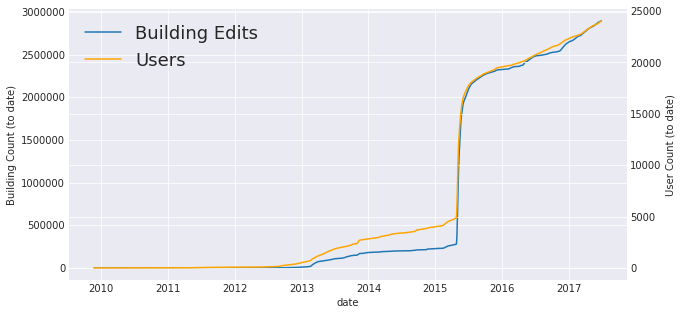

In [248]:
sns.set_style("darkgrid"); axes = []
axes.append( gb_dates.id.cumsum().rolling(window=7).mean().plot(figsize=(10,5)) )
axes.append( gb_dates.user.cumsum().rolling(window=7).mean().plot(figsize=(10,5), color='orange', ax=axes[0].twinx()) )
lines, labels = axes[0].get_legend_handles_labels()
for ax in axes[1:]:
    line, label = ax.get_legend_handles_labels()
    lines += line
axes[-1].legend(lines, ['Building Edits','Users'], loc=0, fontsize=18);
axes[0].set_ylabel('Building Count (to date)');
axes[1].set_ylabel('User Count (to date)');

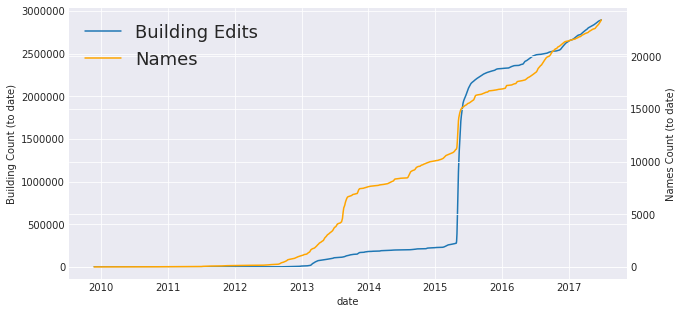

In [249]:
sns.set_style("darkgrid"); axes = []
axes.append( gb_dates.id.cumsum().rolling(window=7).mean().plot(figsize=(10,5)) )
axes.append( gb_dates.name.cumsum().rolling(window=7).mean().plot(figsize=(10,5), color='orange', ax=axes[0].twinx()) )
lines, labels = axes[0].get_legend_handles_labels()
for ax in axes[1:]:
    line, label = ax.get_legend_handles_labels()
    lines += line
axes[-1].legend(lines, ['Building Edits','Names'], loc=0, fontsize=18);
axes[0].set_ylabel('Building Count (to date)');
axes[1].set_ylabel('Names Count (to date)');


In [250]:
buildings.groupby('user').aggregate({'id':'nunique','version':'count','validSince':min,'validUntil':max}).sort_values(by='id',ascending=False)

,id,version,validSince,validUntil
user,,,,
Heinz_V,204121,205616,1424845209,1535673544
Alisha12,114439,120174,1467695745,1535673544
bookbugs,59825,59890,1430035223,1535673544
vichada,45355,45431,1430074413,1535673544
lja60,43933,44773,1430456189,1535673544
Manoj Thapa,43382,45259,1346217945,1535673544
Bishal9841,39041,40765,1458551731,1535673544
Geofreund1,34720,34980,1313697877,1535673544
abel801,33684,33754,1430166308,1535673544


In [260]:
nx.write_graphml(G,'/data/www/jennings/nepal_users.graphml');

In [261]:
gb_user = buildings.groupby('user').aggregate({'validSince':min, 'validUntil':max, 'version':'count','id':'nunique'})

In [268]:
gb_user['firstBuilding'] = gb_user.validSince.apply(lambda t: pd.Timestamp(t*1000000000).date())
gb_user['lastBuilding'] = gb_user.validUntil.apply(lambda t: pd.Timestamp(t*1000000000).date())

In [270]:
gb_user.head()

,validSince,validUntil,version,id,firstBuilding,lastBuilding
user,,,,,,
$agar11,1461967263,1535673544,7,6,2016-04-29,2018-08-30
+rama,1424001018,1424248590,1,1,2015-02-15,2015-02-18
-Christoph-,1429983843,1535673544,463,463,2015-04-25,2018-08-30
0109,1430289805,1431014646,1,1,2015-04-29,2015-05-07
048,1430455711,1535673544,40,40,2015-05-01,2018-08-30


Text(0.5,1,'Timespan of OSM Contributions to Buildings in Nepal')

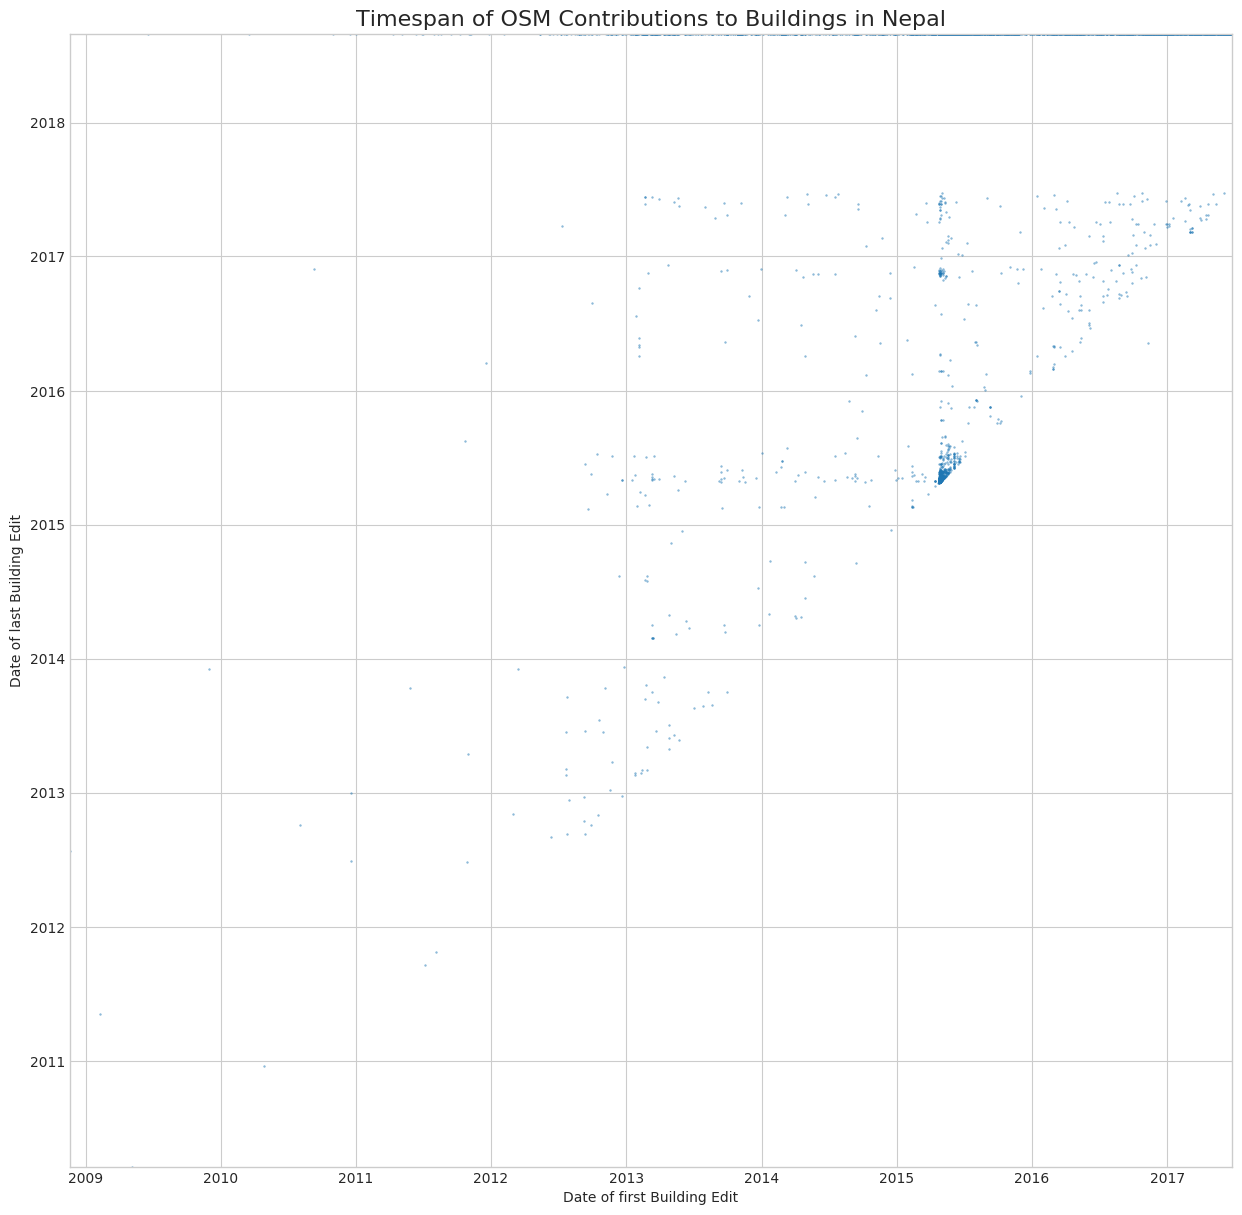

In [275]:
sns.set_style('whitegrid')
plt.figure(num=None, figsize=(15, 15), dpi=100, facecolor='w', edgecolor='k')
plt.plot(gb_user['firstBuilding'], gb_user['lastBuilding'], '+', markersize=2, alpha=0.5)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().yaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().yaxis.set_major_locator(mdates.YearLocator())
plt.xlim([gb_user.firstBuilding.min() , gb_user.firstBuilding.max()])
plt.ylim([gb_user.lastBuilding.min(), gb_user.lastBuilding.max()])
plt.xlabel('Date of first Building Edit')
plt.ylabel('Date of last Building Edit')
plt.title("Timespan of OSM Contributions to Buildings in Nepal",fontsize=16)
# plt.savefig('/data/www/jennings/osm-timespans.png')

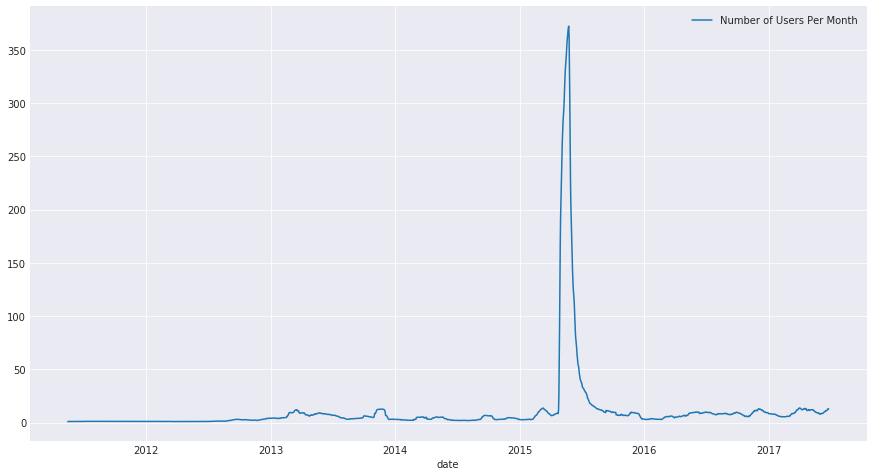

In [310]:
ax = gb_dates.user.rolling(30).mean().plot(figsize=(15,8))
ax.legend(["Number of Users Per Month"])

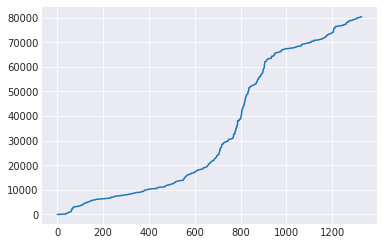

In [337]:
buildings.groupby('date',as_index=False).aggregate({'user':pd.Series.nunique, 'version':sum}).version.cumsum().plot()